### 1. 준비물
- x 데이터 (노이즈 있는 사진)
    - 노이즈 없는 깨끗한 원본사진에 노이즈를 추가하여서 x데이터를 준비
- y 데이터 (노이즈 없는 깨끗한 사진)

In [57]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### 2. 데이터 전처리

- x데이터를 255 => 255. 으로 float64로 형 변환
- x데이터를 /255 으로 나누어서 스케일링을 진행
- gray스케일의 x데이터를 3채널의 컬러로 변경 (skimage gray2rgb)

In [58]:
import numpy as np
np.shape(train_images), np.shape(train_labels), np.shape(test_images)

((60000, 28, 28), (60000,), (10000, 28, 28))

In [59]:
train_images.min(), train_images.max(), test_images.min(), test_images.max()

(0, 255, 0, 255)

`정수형에서 실수형으로 변경`<br>

In [60]:
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)
train_images.min(), train_images.max(), test_images.min(), test_images.max()

(0.0, 255.0, 0.0, 255.0)

In [61]:
train_images.dtype, test_images.dtype

(dtype('float64'), dtype('float64'))

`정규화 또는 표준화 작업`

In [62]:
train_images = train_images/255
test_images = test_images/255

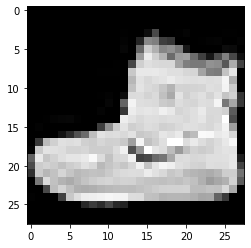

In [63]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0], cmap='gray')

`흑백 이미지를 컬러 이미지로 변경하도록 하겠음. (28,28) => (28,28,3) 으로 변경하면 됨`

In [64]:
# !pip install scikit-image

In [65]:
from skimage import color

train_images = color.gray2rgb(train_images)
test_images = color.gray2rgb(test_images)

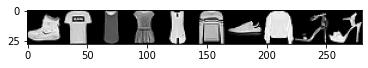

In [66]:
np.shape(train_images)
plt.imshow(train_images[0])
plt.imshow(np.hstack(train_images[:10]))

### 3. 사진에 노이즈 추가
- 노이즈란 : 
- 28, 28, 3 크기의 배열에 0~1 사이값을 무작위로 생성하고자함 

`있어도 되는 노이즈 백색잡음 또는 가우시안 노이즈`

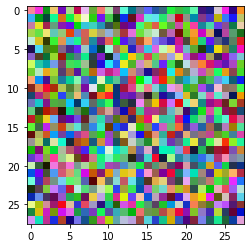

In [67]:
nose = np.random.random((28,28,3))
plt.imshow(nose)

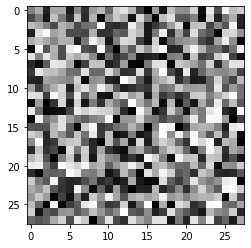

In [68]:
plt.imshow(np.random.random((28,28)), cmap='gray')

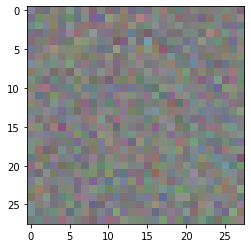

In [69]:
nose = np.random.random((28,28,3))

nose = np.random.normal(0.5,0.05,(28, 28, 3))
plt.imshow(nose)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


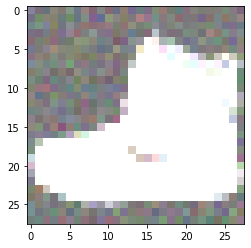

In [70]:
plt.imshow(train_images[0] + nose)

In [71]:
nose.min(), nose.max()

(0.3355214638184637, 0.688125724641955)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


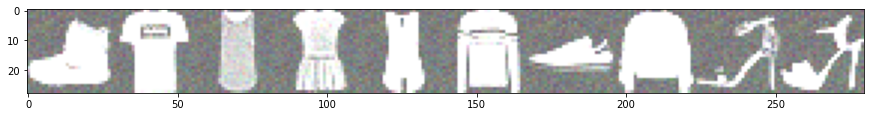

In [72]:
plt.figure(figsize=(15,3))
train_images_noise = train_images+nose
test_images_noise = test_images + nose
plt.imshow(np.hstack(train_images_noise[:10]))

In [73]:
train_images_noise.min(), train_images_noise.max()

(0.3355214638184637, 1.688125724641955)

(0.3355214638184637, 1.0)

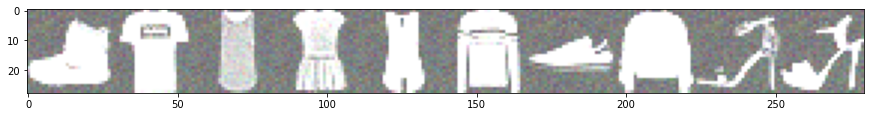

In [74]:
plt.figure(figsize=(15,3))
train_images_noise[train_images_noise > 1.0] = 1.0
plt.imshow(np.hstack(train_images_noise[:10]))

train_images_noise.min(), train_images_noise.max()

### 4. 오토인코더 모델 구성

In [75]:
from tensorflow.keras.layers import Input, Conv2D, Reshape, Flatten, Dense, UpSampling2D
from tensorflow.keras.models import Model

inputs = Input(shape=(28,28,3))
x = Conv2D(32,3,activation = 'relu', padding = 'same')(inputs) # 28*25*3
x = Conv2D(64,3,activation = 'relu', padding = 'same')(x) # 28*28*64
x = Flatten()(x) # 28*28*64 개의 값
last = Dense(10)(x) # 10개의 값 10 * ((28*28*64=50176) + 바이어스 1개) => 10*50177 => 파람 501770개

x = Dense(28*28*64)(last)
x = Reshape((28, 28, 64))(x)
x = Conv2D(64, 3, activation = 'relu', padding='same')(x)
x = Conv2D(32, 3, activation = 'relu', padding='same')(x)
x = Conv2D(3, 1, activation = 'sigmoid', padding='same')(x)


model = Model(inputs, x)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
flatten_9 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 10)                501770    
_________________________________________________________________
dense_19 (Dense)             (None, 50176)             551936    
_________________________________________________________________
reshape_9 (Reshape)          (None, 28, 28, 64)        0   

In [76]:
model.compile(loss='mae',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [91]:
hist = model.fit(train_images_noise, train_images,
                 validation_data = (test_images_noise, test_images),
                epochs = 15)

Epoch 1/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0486 - accuracy: 0.4091 - val_loss: 0.0992 - val_accuracy: 0.5244
Epoch 2/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0485 - accuracy: 0.4124 - val_loss: 0.0967 - val_accuracy: 0.3975
Epoch 3/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0484 - accuracy: 0.4272 - val_loss: 0.0985 - val_accuracy: 0.3770
Epoch 4/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0483 - accuracy: 0.4382 - val_loss: 0.1011 - val_accuracy: 0.8025
Epoch 5/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0483 - accuracy: 0.4357 - val_loss: 0.0979 - val_accuracy: 0.4253
Epoch 6/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0483 - accuracy: 0.4265 - val_loss: 0.0999 - val_accuracy: 0.5040
Epoch 7/15
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0482 - accuracy: 0.4540 - val_loss: 0.0996 - val_ac

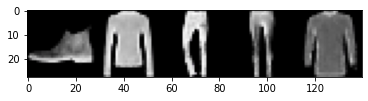

In [92]:
plt.imshow(np.hstack(model.predict(test_images_noise[:5])))

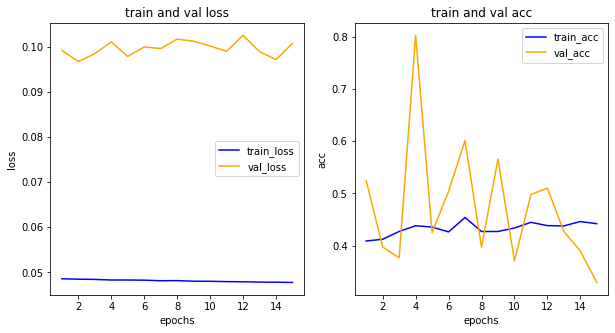

In [93]:
import matplotlib.pyplot as plt

his_dict = hist.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [41]:
from tensorflow.keras.datasets import cifar10

# 데이터를 다운받습니다.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [43]:
x_train_images = x_train.astype(np.float64)
x_test_images = x_test.astype(np.float64)

In [44]:
train_images = x_train_images/255
test_images = x_test_images/255

In [ ]:
plt.figure(figsize = (15,3))
nose = np.random.normal(0.5,0.05,(28, 28, 3))

train_images_noise = train_images + nose